In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import segmentation_models as sm

Segmentation Models: using `tf.keras` framework.


In [31]:
from matplotlib import pyplot as plt
import numpy as np

# Load and prepare data

In [15]:
(train_ds, valid_ds, test_ds), info_ds = tfds.load(
    'oxford_iiit_pet', split=['train', 'test[50:]', 'test[:50]'], 
    with_info=True, data_dir='data/'
)

In [4]:
@tf.function
def map_data(data):
    image, mask = data['image'], data['segmentation_mask']
    
    # Image norm
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, (256, 256))
    image = image / 255.
    
    # Mask norm
    mask = tf.cast(mask, tf.float32)
    mask = tf.image.resize(mask, (256, 256))
    mask -= 1
    mask = tf.cast(mask, tf.int32)
    mask = tf.squeeze(mask, axis=-1)
    mask = tf.one_hot(mask, 3)
    return image, mask

In [5]:
train_ds = train_ds.shuffle(len(train_ds)).map(map_data, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(32).prefetch(tf.data.experimental.AUTOTUNE)
vali_ds = valid_ds.map(map_data, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(32).prefetch(tf.data.experimental.AUTOTUNE)

# Model building
- Build mini version of unet

In [6]:
input_layer = tf.keras.layers.Input(shape=(256, 256, 3))

# First downsampling layer
conv1 = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(input_layer)
pool1 = tf.keras.layers.MaxPooling2D((2, 2))(conv1)

conv2 = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')(pool1)
pool2 = tf.keras.layers.MaxPooling2D((2, 2))(conv2)

ups = tf.keras.layers.Conv2DTranspose(64, (3, 3), strides=(4, 4), activation='relu', padding='same')(pool2)
up3 = tf.keras.layers.concatenate([conv1, ups], axis=3)

conv4 = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(up3)
conv5 = tf.keras.layers.Conv2D(3, (1, 1), activation='softmax')(conv4) # 3 represents the num of classes

model = tf.keras.Model(inputs=input_layer, outputs=conv5)
 
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 128, 128, 64) 0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 128 73856       max_pooling2d[0][0]              
_______________________________________________________________________________________

# Train and plot history

In [7]:
model.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(), 
    optimizer=tf.keras.optimizers.Adam(1e-4), 
    metrics=[sm.metrics.IOUScore(threshold=0.5), 'accuracy', sm.metrics.FScore(threshold=0.5)]
)

In [8]:
history = model.fit(train_ds, validation_data=vali_ds, epochs=10)

Epoch 1/10
  2/115 [..............................] - ETA: 22s - loss: 1.1540 - iou_score: 7.6102e-07 - accuracy: 0.1110 - f1-score: 1.5220e-06WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.1330s vs `on_train_batch_end` time: 0.2468s). Check your callbacks.


115/115 [==============================] - 52s 456ms/step - loss: 0.9632 - iou_score: 0.1218 - accuracy: 0.5648 - f1-score: 0.1663 - val_loss: 0.9322 - val_iou_score: 0.1763 - val_accuracy: 0.5856 - val_f1-score: 0.2304
Epoch 2/10
115/115 [==============================] - 53s 460ms/step - loss: 0.8963 - iou_score: 0.1893 - accuracy: 0.5958 - f1-score: 0.2411 - val_loss: 0.8901 - val_iou_score: 0.1882 - val_accuracy: 0.5856 - val_f1-score: 0.2404
Epoch 3/10
115/115 [==============================] - 52s 456ms/step - loss: 0.8614 - iou_score: 0.1925 - accuracy: 0.5958 - f1-score: 0.2439 - val_loss: 0.8530 - val_iou_score: 0.1833 - val_accuracy: 0.5858 - val_f1-score: 0.2363
Epoch 4/10
115/115 [==============================] - 53s 457ms/step - loss: 0.8319 - iou_score: 0.1895 - accuracy: 0.5979 - f1-score: 0.2413 - val_loss: 0.8265 - val_iou_score: 0.1875 - val_accuracy: 0.6007 - val_f1-score: 0.2400
Epoch 5/10
115/115 [==============================] - 53s 460ms/step - loss: 0.8122 - i

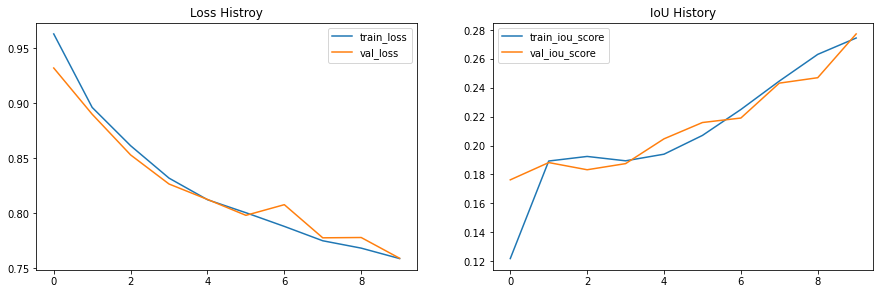

In [14]:
plt.figure(figsize=(15, 10))

plt.subplot(221)
plt.title('Loss Histroy')
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()

plt.subplot(222)
plt.title('IoU History')
plt.plot(history.history['iou_score'], label='train_iou_score')
plt.plot(history.history['val_iou_score'], label='val_iou_score')
plt.legend()

# Evaluation

In [22]:
test = next(iter(test_ds.map(map_data)))

In [44]:
image, gt_mask = test[0], test[1]

In [53]:
pred = model.predict(tf.expand_dims(image, axis=0))[0]
pred = np.argmax(pred, axis=-1)
pred = np.expand_dims(pred, axis=-1)
pred = (pred * (255 / 3)).astype(np.uint8)
pred = np.concatenate([pred, pred, pred], axis=2)

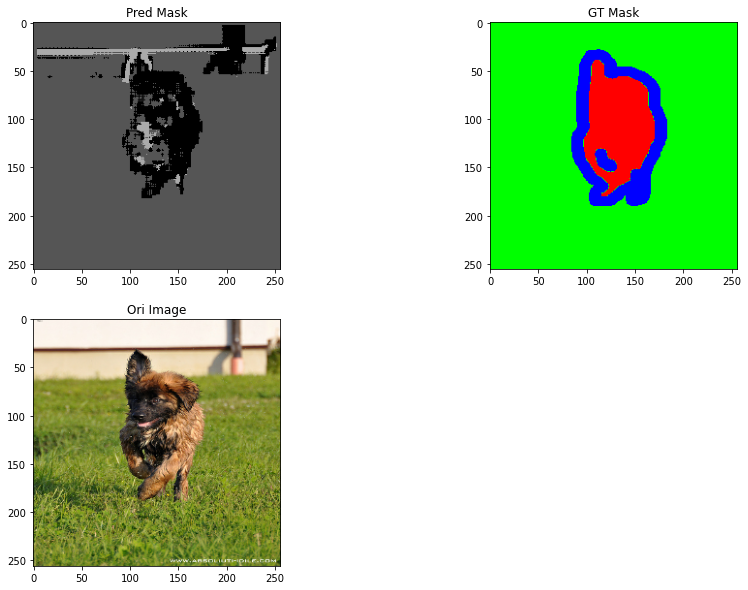

In [55]:
plt.figure(figsize=(15, 10))
plt.subplot(221)
plt.title('Pred Mask')
plt.imshow(pred)

plt.subplot(222)
plt.title('GT Mask')
plt.imshow(gt_mask)

plt.subplot(223)
plt.title('Ori Image')
plt.imshow(image)